# Mother Machine Data Pipeline for Symbiodinium cells

## Prerequsities: 
- your raw data is in tiff-file format (can be converted with eg. bioformats)
- you (manually) create a folder on your computer where you want to store all your results

### Import packages

In [70]:
import os
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from PIL import Image
import imageio
import io
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
import warnings
import tifffile

import skimage
from skimage import io 
from skimage import io as skio, measure, segmentation, color
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.util import img_as_float, img_as_ubyte
from skimage.io import imread, imsave

import napari
from tqdm.notebook import tqdm 
import pandas as pd

import cellpose.models
from cellpose import io as cellpose_io
from cellpose import models


#from deepcell_tracking import CellTracker


### Define filepaths and create directories

In [61]:
"""INPUT PATH TO FOLDER YOU WANT OUTPUTS TO BE IN"""
output_folder = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all"


"""INPUT FILE PATH TO RAW-DATA TIFF-FILE"""
original_tiff_image_series = r"C:\Users\micha\Desktop\Master_Project\ORIGINAL_TIFF_Series_rawdata\new_data\converted_Z1.tiff"


#CREATE FOLDER WHERE ALL RESULTS FROM SPECIFIC RAW-DATA TIFF FILE TO SAVE
base_name = os.path.splitext(os.path.basename(original_tiff_image_series))[0]
result_folder = os.path.join(output_folder, f"MM_pipeline_results_{base_name}")
os.makedirs(result_folder, exist_ok=True)
print(f"Pipeline results for this specific TIFF-file (raw data) will be saved in the directory: {result_folder}")


#CREATE DIRECTORY TO SAVE THE CROPPED TRAPS IN
cropped_traps_output_dir = os.path.join(result_folder, "Cropped_traps_directory")
os.makedirs(cropped_traps_output_dir, exist_ok=True)


#CREATE DIRECTORY TO SAVE SEGMENTATION LABELS IN
labels_directory = Path(os.path.join(result_folder, "Labels_directory"))
labels_directory.mkdir(exist_ok=True)

#CREATE DIRECTORY TO SAVE FILTERED LABELS IN
filtered_labels_directory = Path(os.path.join(result_folder, "Filtered_labels"))
filtered_labels_directory.mkdir(exist_ok=True)

#CREATE DIRECTORY TO SAVE STACKED BRIGHTFIELD
stacked_brightfield = Path(os.path.join(result_folder, "Stacked_Brightfield_dir"))
stacked_brightfield.mkdir(exist_ok=True)


#READ IMAGES INTO PYTHON AND ROTATE THEM 
original_image_series = tifffile.imread(original_tiff_image_series)
rotated_image_series = np.rot90(original_image_series, k=-1, axes=(2, 3))


Pipeline results for this specific TIFF-file (raw data) will be saved in the directory: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1


### View the image series in Napari 
View your raw tiff image file in Napari to make sure it looks good

In [109]:
print("Original shape:", original_image_series.shape)

"""ADD NAMES AND COLORMAP FOR EACH CHANNEL YOU HAVE IN THE IMAGE"""
viewer = napari.view_image(
        rotated_image_series,
        channel_axis=1,
        name=["Brightfield", "Fluoresence (Red)"], #add name for each channel
        colormap=["gray", "red"] #add colormap for each channel
        )


Original shape: (275, 2, 2044, 2048)


### Manual cropping of growth traps/channels for each image 
Manually draw boxes around traps (first frame of the tiff file), the coordinates for these will be saved and then used to crop all subsequent traps

In [4]:
matplotlib.use('Qt5Agg')  # Use 'Qt5Agg' backend

class ManualTrapCropping:
    def __init__(self, image_data, channel_index):
        self.image = image_data[channel_index]
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.image, cmap='gray')  # Display the image as grayscale
        self.rectangles = {}
        self.current_trap_index = 1
        self.first_rect_coords = None
        self.fixed_size = None
        self.rs = RectangleSelector(self.ax, self.on_rectangle_select,
                                     minspanx=5, minspany=5, spancoords='pixels', interactive=True)
        plt.connect('key_press_event', self.on_key_press)

    def on_rectangle_select(self, eclick, erelease):
        if self.fixed_size is None:
            # Store the dimensions of the first rectangle
            self.fixed_size = (erelease.xdata - eclick.xdata, erelease.ydata - eclick.ydata)

        # Use the fixed size for subsequent rectangles
        x_min, y_min = eclick.xdata, eclick.ydata
        x_max, y_max = x_min + self.fixed_size[0], y_min + self.fixed_size[1]

        # Save the rectangle coordinates globally
        global trap_coordinates_dict
        trap_coordinates_dict[self.current_trap_index] = (x_min, y_min, x_max, y_max)

    def on_key_press(self, event):
        if event.key == 'enter':
            # Draw the rectangle on the plot
            rect_coords = trap_coordinates_dict[self.current_trap_index]
            x_min, y_min, x_max, y_max = rect_coords
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            self.ax.add_patch(rect)
            plt.draw()

            # Increment the trap index for the next rectangle
            self.current_trap_index += 1

        elif event.key == 'q':
            # Print the final dictionary of rectangles
            print("Trap coordinates:", trap_coordinates_dict)
            plt.close()

# Initialize the dictionary globally
trap_coordinates_dict = {}

# Specify the channel index you want to crop
channel_index_to_crop = 0  # Adjust this to the desired channel index, best 

# Create an instance of ManualTrapCropping
manual_cropping = ManualTrapCropping(rotated_image_series[0], channel_index_to_crop)
plt.show()


Trap coordinates: {1: (41.293999104343584, 7.0665024630543485, 293.51074787281664, 2041.997089117779), 2: (302.10904612628724, 4.200403045230814, 554.3257948947603, 2039.1309896999555), 3: (1686.4350649350652, 7.0665024630543485, 1938.6518137035382, 2041.997089117779)}



KeyboardInterrupt



### Print height and width for each trap:

In [5]:
def calculate_rectangle_size(trap_coordinates_dict):
    sizes = {}

    for trap_index, coord in trap_coordinates_dict.items():
        x1, y1, x2, y2 = coord
        width = x2 - x1
        height = y2 - y1
        sizes[trap_index] = {'width': width, 'height': height}

    return sizes

# Example usage
rectangle_sizes = calculate_rectangle_size(trap_coordinates_dict)

for trap_index, size in rectangle_sizes.items():
    print(f"Trap {trap_index} Size: Width = {size['width']}, Height = {size['height']}")


Trap 1 Size: Width = 252.21674876847305, Height = 2034.9305866547247
Trap 2 Size: Width = 252.21674876847305, Height = 2034.9305866547247
Trap 3 Size: Width = 252.21674876847305, Height = 2034.9305866547247


### Visualisation of cropped traps
Visualises cropped traps for first and last frame 
- Check first and last frame to assess shifts in X and Y

In [25]:
%matplotlib widget
import matplotlib.pyplot as plt

def crop_visualise_image(image_data, trap_coordinates_dict, channel_index):
    # Create subplots to display the original and cropped traps
    num_traps = len(trap_coordinates_dict)
    fig, axes = plt.subplots(1, num_traps + 1, figsize=(15, 5), squeeze=False)

    # Display the original image in grayscale
    original_channel = image_data[channel_index]
    axes[0, 0].imshow(original_channel, cmap='gray') 
    axes[0, 0].set_title("Original Image")

    # Crop the image based on the rectangles and display each cropped trap
    for i, (trap_index, rect_coords) in enumerate(trap_coordinates_dict.items(), start=1):
        x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values
    
        # Ensure coordinates are within the image boundaries
        x_min = max(0, x_min)
        x_max = min(original_channel.shape[1], x_max)
        y_min = max(0, y_min)
        y_max = min(original_channel.shape[0], y_max)
    
        # Crop the image
        cropped_trap = original_channel[y_min:y_max, x_min:x_max]
    
        # Display the cropped trap in grayscale
        axes[0, i].imshow(cropped_trap, cmap='gray', extent=(x_min, x_max, y_max, y_min))
        axes[0, i].set_title(f"Cropped Trap {trap_index}")

    plt.show()

# Example usage with trap_coordinates_dict and channel_index
channel_index_to_crop = 0 # Adjust this to the desired channel index
crop_visualise_image(rotated_image_series[0], trap_coordinates_dict, channel_index_to_crop)
crop_visualise_image(rotated_image_series[-1], trap_coordinates_dict, channel_index_to_crop)


NameError: name 'rotated_image_series' is not defined

### Crop the traps and save them as tiff-files (4D numpy-arrays (CTYX)) one for each trap
Crops the traps based on the manual selection and saves each trap in different folders which correspond to trap position 

In [7]:

# Define empty arrays
shape_minmax_list= []
cropped_traps_list = []
cropped_traps_dict = {}
# Loop to crop each trap
for trap_index, rect_coords in trap_coordinates_dict.items():
    x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values

    #Ensure trap-coordinates are within the image boundaries
    x_min = max(0, x_min)
    x_max = min(rotated_image_series.shape[-1], x_max)
    y_min = max(0, y_min)
    y_max = min(rotated_image_series.shape[-2], y_max)

    # Crop the image series
    cropped_trap = rotated_image_series[:, :, y_min:y_max, x_min:x_max]

    cropped_traps_dict[trap_index] = cropped_trap

    #add trap X&Y to list
    shape_minmax_list.append((cropped_trap.shape[-1], cropped_trap.shape[-2]))

# Find the maximum values for the first and second elements
transposed_list = list(zip(*shape_minmax_list))
max_X = max(transposed_list[0])
max_Y= max(transposed_list[1])


#for loop to save padded traps in array
for trap_index, cropped_trap in tqdm(cropped_traps_dict.items(), desc="Processing Traps", unit="trap"):
    #calculate padding based on max X&Y
    columns_to_pad = max(0, int(max_X) - cropped_trap.shape[-1])  # Pad along the last dimension (width/X)
    rows_to_pad = max(0, int(max_Y) - cropped_trap.shape[-2])  # Pad along the second-to-last dimension (height/Y)
    
    if columns_to_pad > 0 or rows_to_pad > 0:
        padded_trap = np.pad(cropped_trap, ((0, 0), (0, 0), (0, rows_to_pad), (0, columns_to_pad)), mode='constant', constant_values=0)
    else:
        padded_trap = cropped_trap

    cropped_traps_filename = f"trap_{trap_index}_all_frames_series.tiff"
    cropped_traps_filepath = os.path.join(cropped_traps_output_dir, cropped_traps_filename)
    io.imsave(cropped_traps_filepath, padded_trap)




Processing Traps:   0%|          | 0/3 [00:00<?, ?trap/s]

### View the resulting cropped-trap tiff-files in Napari 
Specify which trap-series to view in the variable "trap_number_to_view"

In [89]:
"""CHANGE THIS TO THE DESIRED TRAP NUMBER TO VIEW"""
trap_number_to_view = 1  

In [9]:
import napari
from skimage import io as skio
from pathlib import Path

def load_trap_series(trap_number):
    # Construct the file path based on the trap number
    file_path = os.path.join(cropped_traps_output_dir, "trap_{}_all_frames_series.tiff".format(trap_number))
    
    # Read the tiff file
    tiff_stack = skio.imread(file_path)
    print(tiff_stack.shape)
    return tiff_stack

# Load the tiff stack for the specified trap
trap_stack = load_trap_series(trap_number_to_view)

# Open Napari viewer
viewer = napari.Viewer()

# Add the tiff stack as a 3D layer
viewer.add_image(trap_stack, name=f'Trap {trap_number_to_view} - All Frames Series', colormap='gray')



(275, 2, 2035, 252)


### CELLPOSE on entire image series and saving labels in Labels_directory

- Parameters for the cellpose model as well as for filtering labels post segemenation

In [24]:
"""DEFINE CELLPOSE MODEL AND IF YOU HAVE GPU"""
model = models.Cellpose(gpu=False, model_type='cyto2')

"""DEFINE CHANNELS"""
#grayscale=0, R=1, G=2, B=3
#[cells, nucleus]
channels_cellpose = [[1, 1]]


"""PARAMETERS FOR THE CELLPOSE MODEL"""
custom_params_segmentation = {
    'diameter': 80.0,
    'interp': 'lanczos3',
    'cellprob_threshold': 0.1,
    'flow_threshold': 0.4,
    'min_size': 500
}


'SPECIFY CHANNEL TO SEGMENT'

In [48]:
import numpy as np
from cellpose import models, io
from skimage import io as skio, measure
import os
from pathlib import Path
from tqdm.notebook import tqdm
import warnings

# Define the input directory for the TIFF files of cropped traps
img_dir = cropped_traps_output_dir

# List all files in the input directory
files_traps_tiff = [f for f in os.listdir(img_dir) if f.endswith('.tiff')]

warnings.filterwarnings("ignore")

# Loop through each tiff file and perform segmentation for all frames
for tiff_file_trap in files_traps_tiff:
    warnings.filterwarnings("ignore")

    # Convert the string filename to a Path object
    tiff_file_trap = Path(tiff_file_trap)

    # Construct the full path to the trap_tiff file
    tiff_path_trap = os.path.join(img_dir, tiff_file_trap)

    # Read the trap_tiff image
    img_trap = io.imread(tiff_path_trap)

    # Create an empty array to store segmented masks for all frames
    masks_trap_all_frames = np.zeros_like(img_trap, dtype=np.uint16)

        # Loop through each frame in the trap_tiff file
    for frame_index, frame in tqdm(enumerate(img_trap), desc=f"Processing frames for {tiff_file_trap}", total=img_trap.shape[0], unit=" frames"):
        # Your existing code for processing each frame
            warnings.filterwarnings("ignore")
    
            # Perform cell segmentation for each frame
            masks_trap, _, _, _ = model.eval(frame, channels=channels_cellpose, **custom_params_segmentation)
        
            # Save the unique cell labels for each frame
            labels_trap_frame = measure.label(masks_trap)
    
            # Accumulate the labels in a new 4D array
            masks_trap_all_frames[frame_index] = labels_trap_frame
            #strip channel dimension to make it 3D
            masks_3D_all_frames = masks_trap_all_frames[:, 0, :, :]
        
            # Save the 3D NumPy array as a single TIFF file in the labels_directory
            labels_file_trap = labels_directory / f"{tiff_file_trap.stem}_test.tiff"
            skio.imsave(labels_file_trap, masks_3D_all_frames.astype(np.uint16), plugin='tifffile')

Processing frames for trap_1_all_frames_series.tiff:   0%|          | 0/275 [00:00<?, ? frames/s]

Processing frames for trap_2_all_frames_series.tiff:   0%|          | 0/275 [00:00<?, ? frames/s]

Processing frames for trap_3_all_frames_series.tiff:   0%|          | 0/275 [00:00<?, ? frames/s]

### Filter and visualize labels (filtered + unfiltered) on traps

- Stack cropped traps for Napari visualisation

In [73]:
#Loads and stacks original files
croppedtrap_frames_list = []

original_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
original_image_file_paths = [str(file_path) for file_path in original_files]

#orginal frame layering: 
for frame_index in tqdm(range(len(tifffile.imread(original_image_file_paths[0]))), desc="Processing Frames"):

    original_frames_for_timepoint = []

    for original_image_tiff in original_image_file_paths:
        original_image_array = tifffile.imread(original_image_tiff)[:, 0, :, :]
        original_frame = original_image_array[frame_index]
        
        original_frames_for_timepoint.append(original_frame)
        
    croppedtrap_stacked_frames_for_timepoint = np.vstack(original_frames_for_timepoint)
    croppedtrap_frames_list.append(croppedtrap_stacked_frames_for_timepoint) 


croppedtrap_frames_array = np.stack(croppedtrap_frames_list)

stacked_brightfield_file = stacked_brightfield / "stacked_brightfield.tiff"
tifffile.imwrite(stacked_brightfield_file, croppedtrap_frames_array)


Processing Frames:   0%|          | 0/275 [00:00<?, ?it/s]

- filter labels

In [54]:
"""PARAMETERS FOR FILTERING LABELS AFTER SEGMENTATION"""
# Filtering thresholds
min_area_threshold = 500
max_area_threshold = 12000
max_circularity_threshold = 0.75


In [55]:
from skimage import measure
import numpy as np

def filter_labels_function(labels, min_area_threshold, max_area_threshold, max_circularity_threshold):
    # Initialize an empty array to store the filtered labels
    filtered_labels = np.zeros_like(labels)
    
    for region in reversed(measure.regionprops(labels)):
        if min_area_threshold < region.area < max_area_threshold and region.eccentricity < max_circularity_threshold:
            # If conditions are met, extract coords
            coords = region.coords
            # If conditions are met, set to 1
            filtered_labels[coords[:, 0], coords[:, 1]] = region.label

    return filtered_labels


In [57]:
import numpy as np
from skimage import measure
import tifffile
import napari
from pathlib import Path
from scipy.ndimage import binary_dilation, binary_erosion

# Load label files as 3D array
filtered_frames_list = []  # List to store individual filtered frames
unfiltered_frames_list = []  # List to store individual filtered frames


labels_files = sorted(Path(labels_directory).glob("*.tiff"))
labels_file_paths = [str(file_path) for file_path in labels_files]



# Iterate over frames for each time point and stack frames across files
for frame_index in tqdm(range(len(tifffile.imread(labels_file_paths[0]))), desc="Processing Frames"):
    
    #create empty lists to store data for time points:
    filtered_frames_for_timepoint = []  
    unfiltered_frames_for_timepoint = []    

    for label_tiff in labels_file_paths: 
        labels_array = tifffile.imread(label_tiff)
        frame = labels_array[frame_index]

               
        filtered_labels = filter_labels_function(frame, min_area_threshold, max_area_threshold, max_circularity_threshold)
        filtered_frames_for_timepoint.append(filtered_labels)
        
        unfiltered_frames_for_timepoint.append(frame)        
        
        

    # Vertically stack frames for each time point across files (filtered labels)
    stacked_frames_for_timepoint = np.vstack(filtered_frames_for_timepoint)
    filtered_frames_list.append(stacked_frames_for_timepoint)
    
    #stack unfiltered labels
    unfiltered_stacked_frames_for_timepoint = np.vstack(unfiltered_frames_for_timepoint)
    unfiltered_frames_list.append(unfiltered_stacked_frames_for_timepoint)

# Combine the stacked frames for all time points into a single array

filtered_frames_array = np.stack(filtered_frames_list)
unfiltered_frames_array = np.stack(unfiltered_frames_list)

#Saves the vertically stacked filtered labels for the timepoints
Path_filtered = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Filtered_labels\filtered_labels.tiff"
tifffile.imsave(Path_filtered, filtered_frames_array)

Processing Frames:   0%|          | 0/275 [00:00<?, ?it/s]

- visualise vertical stacks of filtered and unfiltered labels, as well as brightfield stack in napari

In [67]:
#Stacked brightfield
stacked_brightfield_file = stacked_brightfield / "stacked_brightfield.tiff"
brightfield_stack = tifffile.imread(stacked_brightfield_file)

## Display the combined stacked arrays as a single layer in Napari
viewer = napari.Viewer()
viewer.add_image(filtered_frames_array, name="Filtered Labels", colormap = "red", scale=[1, 1, 1])
viewer.add_image(unfiltered_frames_array, name="Unfiltered Labels", colormap = "green", scale=[1, 1, 1])
viewer.add_image(brightfield_stack, name="Cropped Traps", scale=[1, 1, 1])




<Image layer 'Cropped Traps' at 0x2367b38f3d0>

### Extract region props from the images
- extracts from filtered labels stack

In [59]:
from skimage import measure
import numpy as np
import tifffile
from pathlib import Path

# Specify the directory containing TIFF files
tiff_directory = Path(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Filtered_labels")

# Get a list of TIFF file paths in the directory
tiff_files = sorted(tiff_directory.glob("*.tiff"))

# Create an empty dictionary to store region properties
regionprops_dict = {}

# Iterate over TIFF files in the directory
for tiff_path in tiff_files:
    # Read the TIFF file
    tiff_array = tifffile.imread(tiff_path)

    # Iterate over time points in the TIFF array
    for timepoint, frame in enumerate(tiff_array, start=1):  # Start timepoint index from 1
        # Convert the binary image to an integer type
        labeled_frame = measure.label(frame.astype(np.uint16))

        # Extract region properties from the labeled frame
        region_props_dict = {}
        for region in measure.regionprops(labeled_frame):
            label_key = f"label {region.label}"
            label_props = {
                "area": region.area,
                "centroid": region.centroid,
                "equivalent_diameter": 2 * np.sqrt(region.area / np.pi),
                "eccentricity": region.eccentricity,
                # Add more properties as needed
            }
            region_props_dict[label_key] = label_props

        # Add region properties to the overall dictionary with frame and label keys
        frame_key = f"frame {timepoint}"
        regionprops_dict.setdefault(frame_key, {}).update(region_props_dict)

# Now, regionprops_dict contains region properties for each timepoint and label with frame and label keys
print(regionprops_dict)


{'frame 1': {'label 1': {'area': 8554.0, 'centroid': (288.6833060556465, 133.96609773205518), 'equivalent_diameter': 104.36134852360131, 'eccentricity': 0.41217947318336495}, 'label 2': {'area': 7777.0, 'centroid': (511.03227465603703, 130.04268998328405), 'equivalent_diameter': 99.50871288186457, 'eccentricity': 0.4326010659490607}, 'label 3': {'area': 8479.0, 'centroid': (2311.4691590989505, 144.74725793135983), 'equivalent_diameter': 103.90283008565957, 'eccentricity': 0.4001324073018398}, 'label 4': {'area': 7718.0, 'centroid': (3072.754340502721, 140.51373412801243), 'equivalent_diameter': 99.13053417724524, 'eccentricity': 0.6735521060749534}, 'label 5': {'area': 8705.0, 'centroid': (3507.971510626077, 140.83549684089604), 'equivalent_diameter': 105.27844146319602, 'eccentricity': 0.10755133746009037}, 'label 6': {'area': 7353.0, 'centroid': (4901.060791513668, 135.17775057799537), 'equivalent_diameter': 96.75810236066876, 'eccentricity': 0.36453854009848036}, 'label 7': {'area':

### plotting: 

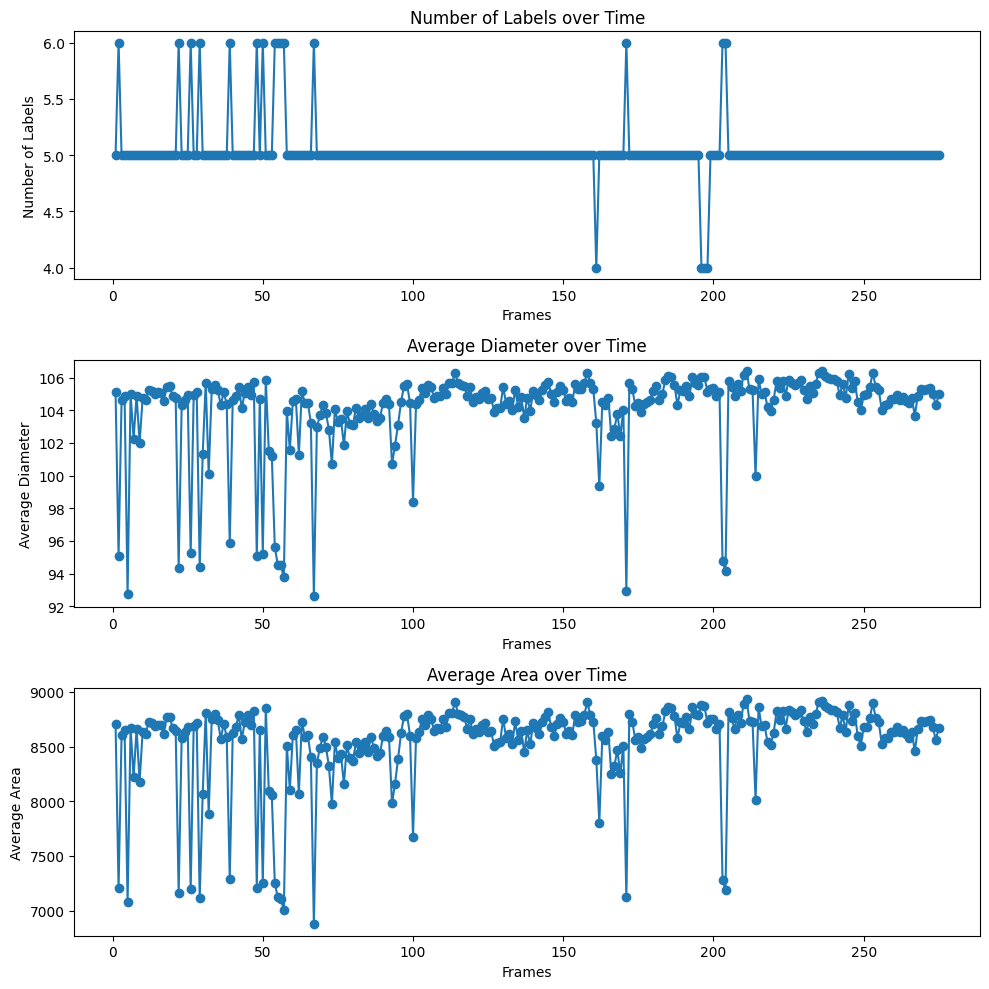

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
timepoints = sorted(regionprops_dict.keys())
num_labels = [len(regionprops) for timepoint, regionprops in regionprops_dict.items()]
average_areas = [np.mean([props["area"] for props in regionprops.values()]) for timepoint, regionprops in regionprops_dict.items()]
average_diameters = [np.mean([props["equivalent_diameter"] for props in regionprops.values()]) for timepoint, regionprops in regionprops_dict.items()]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot Number of Labels
axs[0].plot(timepoints, num_labels, marker='o')
axs[0].set_title('Number of Labels over Time')
axs[0].set_xlabel('Frames')
axs[0].set_ylabel('Number of Labels')

# Plot Average Diameter
axs[1].plot(timepoints, average_diameters, marker='o')
axs[1].set_title('Average Diameter over Time')
axs[1].set_xlabel('Frames')
axs[1].set_ylabel('Average Diameter')

# Plot Average Area
axs[2].plot(timepoints, average_areas, marker='o')
axs[2].set_title('Average Area over Time')
axs[2].set_xlabel('Frames')
axs[2].set_ylabel('Average Area')

plt.tight_layout()
plt.show()


- Individual labels

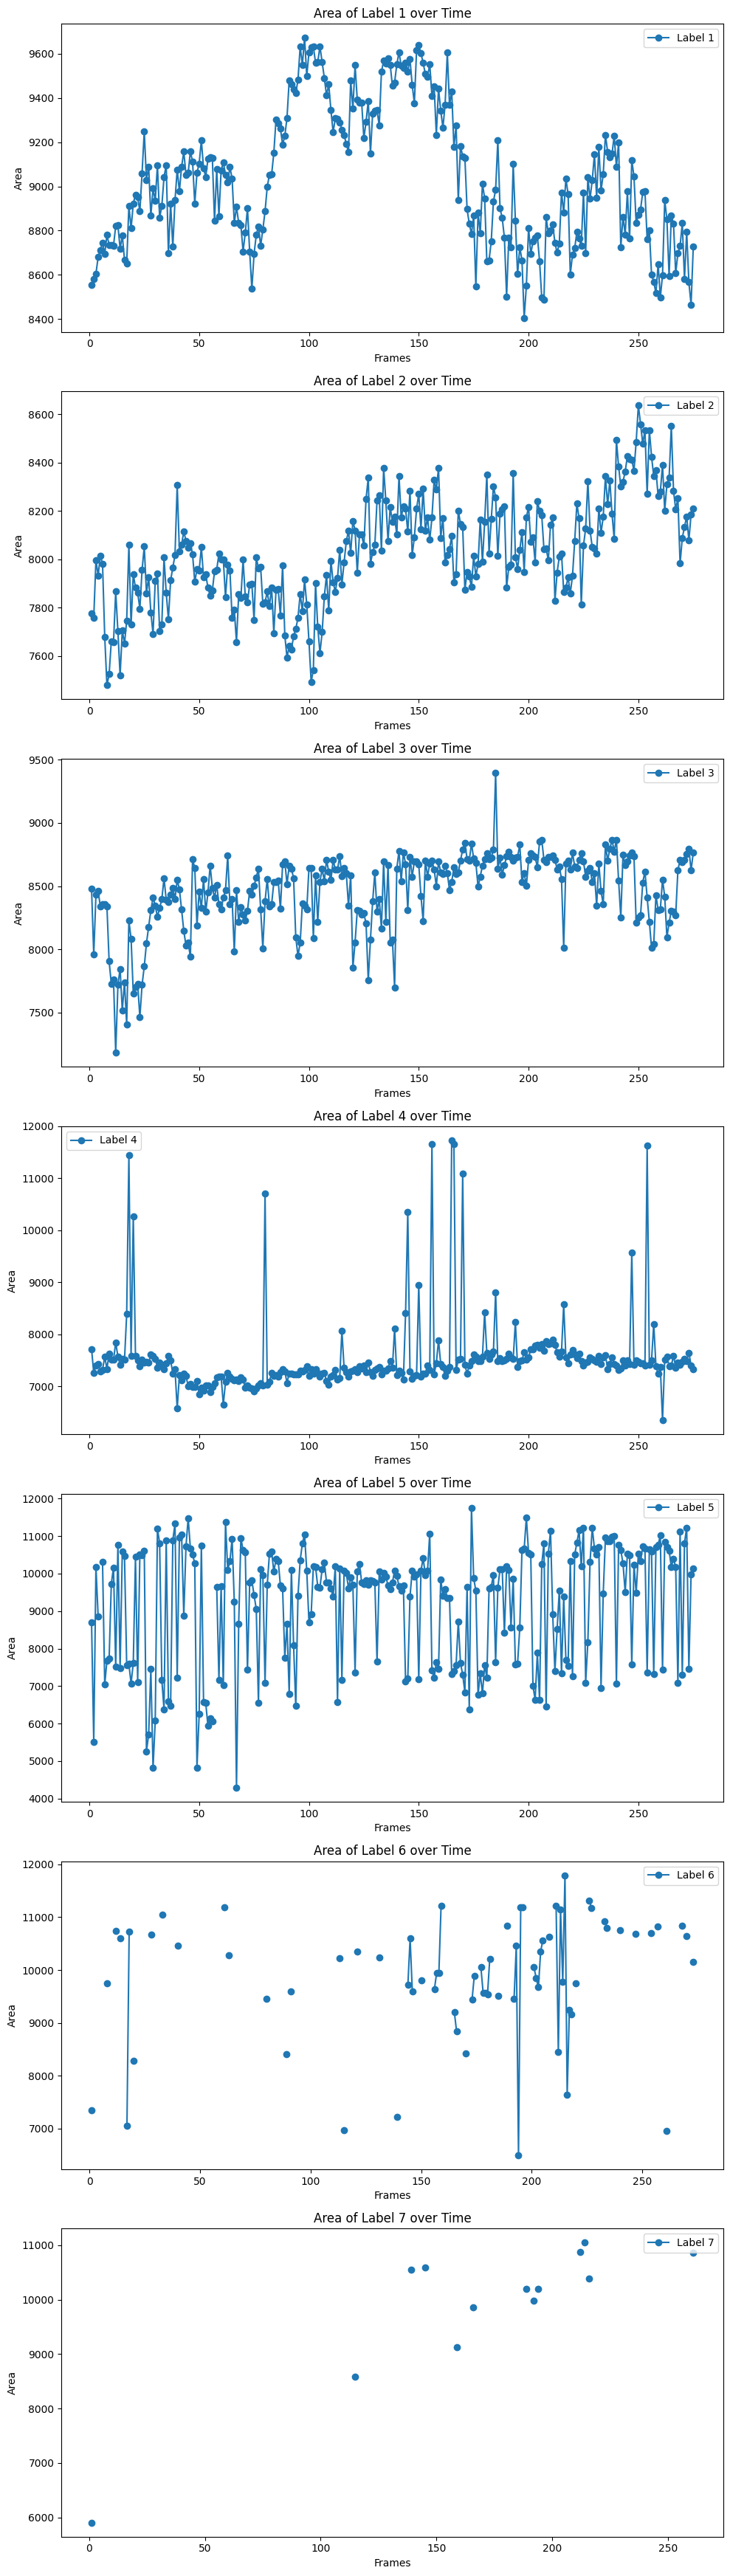

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
timepoints = list(range(1, len(regionprops_dict) + 1))

# Create a separate plot for each label
fig, axs = plt.subplots(len(regionprops_dict['frame 1']), 1, figsize=(10, 5 * len(regionprops_dict['frame 1'])))

for label_num in range(1, len(regionprops_dict['frame 1']) + 1):
    # Check if the label exists in any frame
    if any(f'label {label_num}' in regionprops_dict[f'frame {t}'] for t in timepoints):
        # Extract data for the current label over time
        area_data = [regionprops_dict.get(f'frame {t}', {}).get(f'label {label_num}', {}).get('area', np.nan) for t in timepoints]

        # Plotting
        axs[label_num - 1].plot(timepoints, area_data, marker='o', label=f'Label {label_num}')
        axs[label_num - 1].set_title(f'Area of Label {label_num} over Time')
        axs[label_num - 1].set_xlabel('Frames')
        axs[label_num - 1].set_ylabel('Area')
        axs[label_num - 1].legend()

plt.tight_layout()
plt.show()
